In [1]:
#libraries
import os, glob
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#from keras.models import Sequential
#from keras.models import Dense

#from tensorflow.python import tf2
#from keras import distribute

In [2]:
#using House Price Prediction dataset from Kaggle 
#https://www.kaggle.com/c/neolen-house-price-prediction/overview

#load House Price Prediction data
house = pd.read_csv('train.csv')
house.head()
house = pd.DataFrame(house)

In [3]:
#how many columns and rows?
#house_train.shape
c_list = list(house)
print(house)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1254  1255          60       RL         60.0     6931   Pave   NaN      Reg   
1255  1256          50       RM         52.0     6240   Pave   NaN      Reg   
1256  1257          20       RL         91.0    14303   Pave   NaN      IR1   
1257  1258          30       RL         56.0     4060   Pave   NaN      Reg   
1258  1259          80       RL         59.0     9587   Pave   NaN      IR1   

     LandContour Utilities  ... PoolArea PoolQC Fen

In [4]:
#PREPROCESSING TRAINING DATA

#1st column (ID) is irrelevant, dropping 
house = house.iloc[: , 1:]

#find number of NA values in each column
house.isna().sum()

#identify columns with NA values
na = [i for i in house.columns if house[i].isnull().sum() > 0 *len(house)]
print(na)
#how many NAs for each column?
na_cols = house[['MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']]
print(na_cols.isna().sum())

#removing columns with missing values because either (1) column has very high # of NAs or (2) column is a small detail e.g. 'masonry veneer type'
house = house.drop(labels=['MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
MasVnrType         7
MasVnrArea         7
BsmtQual          35
BsmtCond          35
BsmtExposure      36
BsmtFinType1      35
BsmtFinType2      36
FireplaceQu      599
GarageType        71
GarageYrBlt       71
GarageFinish      71
GarageQual        71
GarageCond        71
PoolQC          1255
Fence           1019
MiscFeature     1208
dtype: int64


In [5]:
#inspect column types
house.dtypes.value_counts()

#select columns by 'object' type
house.select_dtypes('object').columns.to_list()

#reference: http://rstudio-pubs-static.s3.amazonaws.com/411830_faa32213605444738e864319dcc5d25e.html
house = house.replace({"Alley" : {" " : 0, "Grvl" : 1, "Pave" : 2},
"BldgType" : {"1Fam" : 1, "2fmCon" : 2, "Duplex" : 3, "Twnhs": 4, "TwnhsE" : 5},
"BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
"BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
"BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
"BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
"BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
"CentralAir" : {"N" : 0, "Y" : 1},
"Condition1" : {"Artery" : 1, "Feedr" : 2, "Norm" : 3, "RRNn": 4, "RRAn" : 5, "PosN" : 6, "PosA" : 7, "RRNe" : 8, "RRAe" : 9},
"Condition2" : {"Artery" : 1, "Feedr" : 2, "Norm" : 3, "RRNn": 4, "RRAn" : 5, "PosN" : 6, "PosA" : 7, "RRNe" : 8, "RRAe" : 9},
"Electrical" : {"SBrkr" : 1, "FuseA" : 2, "FuseF" : 3, "FuseP": 4, "Mix" : 5},
"ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
"ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
"Exterior1st" : {"AsbShng" : 1, "AsphShn" : 2, "BrkComm": 3, "BrkFace": 4, "CBlock" : 5, "CemntBd" : 6, "HdBoard" : 7,
                "ImStucc" : 8, "MetalSd" : 9, "Other" : 10, "Plywood" : 11, "PreCast" : 12, "Stone" : 13, "Stucco" : 14,
                "VinylSd" : 15, "Wd Sdng" : 16, "WdShing" : 17},   
"Exterior2nd" : {"AsbShng" : 1, "AsphShn" : 2, "Brk Cmn": 3, "BrkFace": 4, "CBlock" : 5, "CmentBd" : 6, "HdBoard" : 7,
                "ImStucc" : 8, "MetalSd" : 9, "Other" : 10, "Plywood" : 11, "PreCast" : 12, "Stone" : 13, "Stucco" : 14,
                "VinylSd" : 15, "Wd Sdng" : 16, "Wd Shng" : 17}, 
"FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
"Foundation" : {"BrkTil" : 1, "CBlock" : 2, "PConc" : 3, "Slab": 4, "Stone" : 5, "Wood" : 6},
"Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
"GarageCond" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
"GarageQual" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},            
"HouseStyle" : {"1Story" : 1, "1.5Fin" : 2, "1.5Unf": 3, "2Story": 4, "2.5Fin" : 5, "2.5Unf" : 6, "SFoyer" : 7, "SLvl" : 8},  
"Heating" : {"Floor" : 1, "GasA" : 2, "GasW" : 3, "Grav" : 4, "OthW": 5, "Wall" : 6},
"HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
"KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
"LandContour" : {"Lvl" : 1, "Bnk" : 2, "HLS" : 3, "Low" : 4},              
"LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
"LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
"LotConfig" : {"Inside" : 1, "Corner" : 2, "CulDSac" : 3, "FR2" : 4, "FR3": 5},
"MSZoning" : {"A" : 1, "C (all)" : 2, "FV" : 3, "I" : 4, "RH" : 5, "RL" : 6, "RP" : 7, "RM" : 8},   
"Neighborhood" : {"Blmngtn" : 1, "Blueste" : 2, "BrDale" : 3, "BrkSide" : 4, "CollgCr" : 5, "Crawfor" : 6, "Edwards" : 7,
                 "Gilbert" : 8, "IDOTRR" : 9, "MeadowV" : 10, "Mitchel" : 11, "NAmes" : 12, "NoRidge" : 13,
                 "NPkVill" : 14, "NridgHt" : 15, "NWAmes" : 16, "OldTown" : 17, "SWISU" : 18, "Sawyer" : 19,
                 "SawyerW" : 20, "Somerst" : 21, "StoneBr" : 22, "Timber" : 23, "Veenker" : 24, "ClearCr" : 25},
"PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
"PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
"Street" : {"Grvl" : 1, "Pave" : 2},
"RoofStyle" : {"Flat" : 1, "Gable" : 2, "Gambrel" : 3, "Hip" : 4, "Mansard" : 5, "Shed" : 6},
"RoofMatl" : {"ClyTile" : 1, "CompShg" : 2, "Membran" : 3, "Metal" : 4, "Roll" : 5, "Tar&Grv" : 6, "WdShake" : 7, "WdShngl" : 8},
"SaleType" : {"WD" : 1, "CWD" : 2, "VWD" : 3, "New" : 4, "COD" : 5, "Con" : 6, "ConLw" : 7, "ConLI" : 8, "ConLD" : 9, "Oth" : 10},
"SaleCondition" : {"Normal" : 1, "Abnorml" : 2, "AdjLand" : 3, "Alloca" : 4, "Family": 5, "Partial" : 6},
"Utilities" : {"None" : 0, "ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}} )

In [6]:
#set na values from 'Alley' column to 0, convert to integer-type
house['Alley'] = house['Alley'].fillna(0)
house.Alley = house.Alley.astype(int)

#set na values from 'LotFrontage' column to 0, convert to integer-type
house['LotFrontage'] = house['LotFrontage'].fillna(0)
house.LotFrontage = house.LotFrontage.astype(int)

In [7]:
#Pearson correlation coefficient
#determine measure of strength and direction between feature variables and SalePrice

pd.options.display.max_rows = 100

house.corr()['SalePrice'].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790786
GrLivArea        0.733480
ExterQual        0.683942
KitchenQual      0.662928
GarageCars       0.642079
TotalBsmtSF      0.641946
GarageArea       0.625499
1stFlrSF         0.617868
FullBath         0.566303
TotRmsAbvGrd     0.552707
YearBuilt        0.524407
YearRemodAdd     0.512674
Fireplaces       0.460081
HeatingQC        0.433321
BsmtFinSF1       0.409673
Foundation       0.376264
2ndFlrSF         0.335212
WoodDeckSF       0.316402
OpenPorchSF      0.315975
SaleCondition    0.314111
HalfBath         0.298473
LotArea          0.267146
CentralAir       0.246015
LotFrontage      0.238979
PavedDrive       0.237730
RoofStyle        0.231943
BsmtFullBath     0.223671
BsmtUnfSF        0.207560
Neighborhood     0.205126
BedroomAbvGr     0.170714
SaleType         0.156338
RoofMatl         0.136867
ScreenPorch      0.123616
Exterior1st      0.114793
Functional       0.108725
Exterior2nd      0.105950
PoolArea         0.101972
LotConfig   

In [8]:
#linear regression using features w/ highest correlation-coefficient
#corr-coeff
X = house[["OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars",
        "TotalBsmtSF", "GarageArea", "1stFlrSF", "FullBath", "TotRmsAbvGrd"]]
y = house[["SalePrice"]]

#normalize feature variables
from sklearn.preprocessing import StandardScaler
X_features = X
X = StandardScaler().fit_transform(X)

#fitting to model
mlr = LinearRegression()
X = sm.add_constant(X)
 
lr_model = sm.OLS(y, X).fit()
print(lr_model.summary())
print("Parameters: ", lr_model.params)
print("R2: ", lr_model.rsquared)

#R-squared: 0.8072472445656957, using the 10 columns with highest correlation to sales price.
#Using only subset of features to determine the most significant.

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     522.7
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:08:48   Log-Likelihood:                -14973.
No. Observations:                1259   AIC:                         2.997e+04
Df Residuals:                    1248   BIC:                         3.002e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.811e+05   1001.131    180.940      0.0

In [9]:
#fitting to train/test datasets
#reference: https://medium.com/the-code-monster/split-a-dataset-into-train-and-test-datasets-using-sk-learn-acc7fd1802e0
#train and test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 10)

clf = LinearRegression()
clf.fit(X_train,y_train)
clf.predict(X_test)
clf.score(X_test,y_test)

#RMSE
from sklearn import metrics
y_pred = clf.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#RMSE: 33312.13597853629
#R squared: 0.8231051793884099

33312.13597853629


In [10]:
#linear regression using features w/ lowest p-values
X_all = pd.DataFrame(house.iloc[:,0:80]) 
y_all = house[["SalePrice"]]

mlr = LinearRegression()
est = sm.OLS(y_all, X_all.astype(float)).fit()
 
lr_model = sm.OLS(y_all, X_all).fit()
print(lr_model.summary())

#top 10 with lowest p-value:
#LotFrontage, MSZoning, PoolArea, Neighborhood, 1stFlrSF, BsmtHalfBath, Foundation, MSSubClass, LandContour, MoSold

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.707e+30
Date:                Wed, 09 Mar 2022   Prob (F-statistic):                        0.00
Time:                        19:09:03   Log-Likelihood:                          24814.
No. Observations:                1259   AIC:                                 -4.950e+04
Df Residuals:                    1197   BIC:                                 -4.919e+04
Df Model:                          62                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [11]:
#top 10 features with lowest p-value
X_pval = house[["LotFrontage", "MSZoning", "PoolArea", "Neighborhood", "1stFlrSF", "BsmtHalfBath", 
               "Foundation", "MSSubClass", "LandContour", "MoSold"]]

# normalize feature variables
from sklearn.preprocessing import StandardScaler
X_features = X_pval
X_pval = StandardScaler().fit_transform(X_pval)


In [12]:
#fitting to entire dataset
mlr = LinearRegression()
X_pval = sm.add_constant(X_pval)

 
lr_model = sm.OLS(y, X_pval).fit()
print(lr_model.summary())
print("Parameters: ", lr_model.params)
print("R2: ", lr_model.rsquared)


#R-squared: 0.48320147754933096, using the 10 columns with lowest p-values to sales price.
#LOWER ACCURACY COMPARED TO FEATURES WITH HIGHEST CORR-COEFF VALUE

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     116.7
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          4.56e-171
Time:                        19:09:23   Log-Likelihood:                -15593.
No. Observations:                1259   AIC:                         3.121e+04
Df Residuals:                    1248   BIC:                         3.127e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.811e+05   1639.273    110.503      0.0

In [13]:
#fitting to train/test datasets
#reference: https://medium.com/the-code-monster/split-a-dataset-into-train-and-test-datasets-using-sk-learn-acc7fd1802e0
#train and test split (70/30)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pval, y, test_size=0.30, random_state = 10)

clf = LinearRegression()
clf.fit(X_train2,y_train2)
clf.predict(X_test2)
clf.score(X_test2,y_test2)

#RMSE
from sklearn import metrics
y_pred2 = clf.predict(X_test2)
print(np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)))

#R squared: 0.4735340673855917
#RMSE: 57468.52607796501



57468.52607796501


Target looks like regression


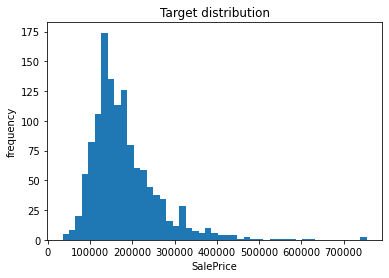

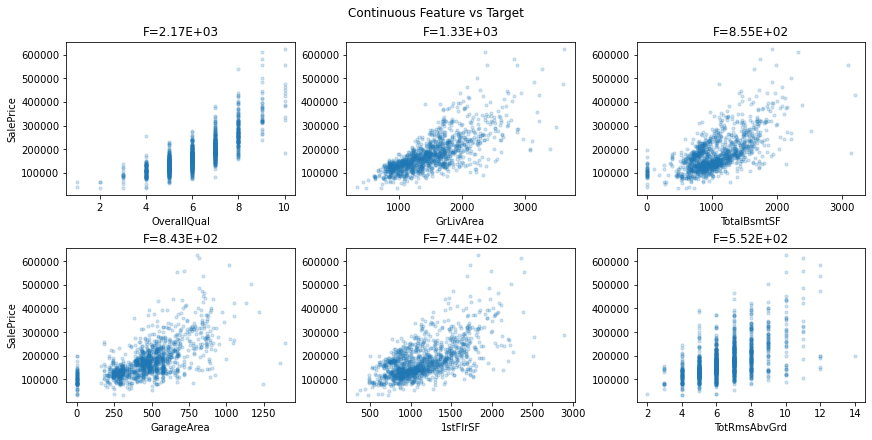

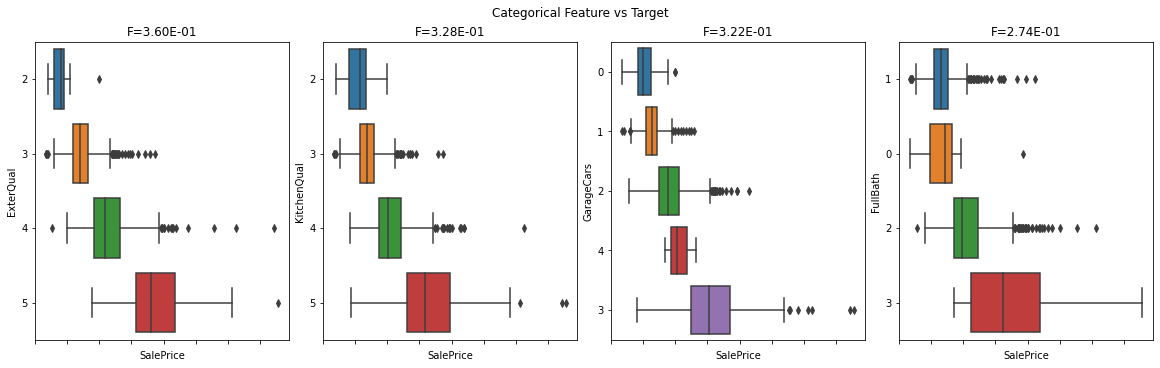

In [15]:
#TOP 10 FEATURE VARIABLES WITH HIGHEST CORRELATION COEFFICIENT HAVE BETTER ACCURACY COMPARED TO TOP 10 FEATURE 
#VARIABLES WITH LOWEST P-VALUES
#we will use features with highest corr-coeff
#create scatterplot matrix of top 10 feature variables with highest correlation coefficient
top10 = house[["OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars",
        "TotalBsmtSF", "GarageArea", "1stFlrSF", "FullBath", "TotRmsAbvGrd", "SalePrice"]]

from dabl import plot
plot(top10, 'SalePrice')
plt.show()

#hide warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [27]:
#Random Forest Regressor 

X = house[["OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars",
        "TotalBsmtSF", "GarageArea", "1stFlrSF", "FullBath", "TotRmsAbvGrd"]]
y = house[["SalePrice"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 10)


#Random Forest Regressor 
random_forest = RandomForestRegressor() 

rfr = RandomForestRegressor(n_estimators = 500, max_depth=3)
rfr.fit(X_train, y_train.values.ravel())
rfr_predict = rfr.predict(X_train)

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test) 

#Measuring Training data

from sklearn import metrics
print('R squared:',metrics.r2_score(y_train, rfr.predict(X_train)))  

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#R squared: 0.8087493253769742
#Root Mean Squared Error: 28476.23027421693

R squared: 0.8106618093227411
Root Mean Squared Error: 28498.18254613284


In [41]:
from sklearn.svm import SVC

#SVM w/ highest correlation-coefficient
#corr-coeff
X = house[["OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars",
        "TotalBsmtSF", "GarageArea", "1stFlrSF", "FullBath", "TotRmsAbvGrd"]]
y = house[["SalePrice"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 10)


#normalize feature variables

X_features = X
X = StandardScaler().fit_transform(X)

model = SVC (kernel = 'linear', degree = 3)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

#print results
print('SVM Accuracy on data')
print(accuracy_score(y_test, predictions))
print('SVM Confusion matrix of data')
print(confusion_matrix(y_test, predictions))
print('SVM Classification report on data')
print(classification_report(y_test, predictions))

SVM Accuracy on data
0.0026455026455026454
SVM Confusion matrix of data
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SVM Classification report on data
              precision    recall  f1-score   support

       34900       0.00      0.00      0.00         1
       35311       0.00      0.00      0.00         1
       37900       0.00      0.00      0.00         0
       39300       0.00      0.00      0.00         1
       40000       0.00      0.00      0.00         1
       52000       0.00      0.00      0.00         0
       55000       0.00      0.00      0.00         0
       60000       0.00      0.00      0.00         2
       61000       0.00      0.00      0.00         1
       62383       0.00      0.00      0.00         0
       66500       0.00      0.00      0.00         0
       67000       0.00      0.00      0.00         0
       68500       0.00      0.00      0.00         1
       73000     